<a href="https://colab.research.google.com/github/Zunuoh/Dengue-Fever-Prediction/blob/main/New_Dengue_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import sklearn as sk
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import logging

In [60]:
df = pd.read_csv('climate_disease_dataset.csv')
df.head()

,year,month,country,region,avg_temp_c,precipitation_mm,air_quality_index,uv_index,malaria_cases,dengue_cases,population_density,healthcare_budget
0,2000,1,Palestinian Territory,Central,28.132,152.084,110.487,12.000,53,145,113,1068
1,2000,2,Palestinian Territory,Central,30.886,119.591,83.468,12.000,132,48,113,1068
2,2000,3,Palestinian Territory,Central,31.366,95.876,93.095,12.000,34,80,113,1068
3,2000,4,Palestinian Territory,Central,28.482,175.316,105.530,9.396,23,133,113,1068
4,2000,5,Palestinian Territory,Central,26.890,191.446,60.206,9.936,39,74,113,1068


In [61]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,34560.000,2011.500,6.922,2000.000,2005.750,2011.500,2017.250,2023.000
month,34560.000,6.500,3.452,1.000,3.750,6.500,9.250,12.000
avg_temp_c,34560.000,20.395,8.411,-2.557,14.404,20.352,26.343,44.584
precipitation_mm,34560.000,192.668,90.504,0.000,124.641,195.315,260.148,485.704
air_quality_index,34560.000,43.788,33.080,0.000,15.323,40.686,68.402,168.848
uv_index,34560.000,10.211,1.937,0.871,8.921,10.761,12.000,12.000
malaria_cases,34560.000,70.520,46.131,0.000,32.000,69.000,107.000,201.000
dengue_cases,34560.000,75.941,37.324,0.000,48.000,76.000,104.000,181.000
population_density,34560.000,266.900,136.001,50.000,136.250,277.500,384.750,498.000
healthcare_budget,34560.000,2764.650,1418.119,205.000,1435.500,2859.000,3996.750,4969.000


In [62]:
df.isnull().sum()

,0
year,0
month,0
country,0
region,0
avg_temp_c,0
precipitation_mm,0
air_quality_index,0
uv_index,0
malaria_cases,0
dengue_cases,0


In [24]:
print(len(df))

34560


In [25]:
df.duplicated().sum()

np.int64(0)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                34560 non-null  int64  
 1   month               34560 non-null  int64  
 2   country             34560 non-null  object 
 3   region              34560 non-null  object 
 4   avg_temp_c          34560 non-null  float64
 5   precipitation_mm    34560 non-null  float64
 6   air_quality_index   34560 non-null  float64
 7   uv_index            34560 non-null  float64
 8   malaria_cases       34560 non-null  int64  
 9   dengue_cases        34560 non-null  int64  
 10  population_density  34560 non-null  int64  
 11  healthcare_budget   34560 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 3.2+ MB


In [27]:
df['country'] = df['country'].astype('category')
df['region'] = df['region'].astype('category')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   year                34560 non-null  int64   
 1   month               34560 non-null  int64   
 2   country             34560 non-null  category
 3   region              34560 non-null  category
 4   avg_temp_c          34560 non-null  float64 
 5   precipitation_mm    34560 non-null  float64 
 6   air_quality_index   34560 non-null  float64 
 7   uv_index            34560 non-null  float64 
 8   malaria_cases       34560 non-null  int64   
 9   dengue_cases        34560 non-null  int64   
 10  population_density  34560 non-null  int64   
 11  healthcare_budget   34560 non-null  int64   
dtypes: category(2), float64(4), int64(6)
memory usage: 2.7 MB


In [30]:
region_dummies = pd.get_dummies(df['region'], prefix="region")
country_dummies = pd.get_dummies(df['country'], prefix='country')

df = pd.concat([df, region_dummies, country_dummies], axis=1)

In [31]:
country_columns = [col for col in df.columns if col.startswith('country_')]
country_cases = df[country_columns].multiply(df['dengue_cases'], axis=0).sum()
country_cases = country_cases.reset_index()
country_cases.columns = ['Country', 'Total Cases']


region_columns = [col for col in df.columns if col.startswith('region_')]
region_cases = df[region_columns].multiply(df['dengue_cases'], axis=0).sum()
region_cases = region_cases.reset_index()
region_cases.columns = ['Region', 'Total Cases']

In [32]:
print(country_columns)
print(region_columns)

['country_American Samoa', 'country_Antarctica (the territory South of 60 deg S)', 'country_Antigua and Barbuda', 'country_Armenia', 'country_Aruba', 'country_Azerbaijan', 'country_Bahamas', 'country_Bangladesh', 'country_Barbados', 'country_Belgium', 'country_Brazil', 'country_Bulgaria', 'country_Burkina Faso', 'country_Cambodia', 'country_Chad', 'country_Chile', 'country_Christmas Island', 'country_Cocos (Keeling) Islands', 'country_Colombia', 'country_Congo', 'country_Cuba', 'country_Cyprus', 'country_Czech Republic', 'country_Denmark', 'country_Djibouti', 'country_Dominica', 'country_Dominican Republic', 'country_Ecuador', 'country_Egypt', 'country_El Salvador', 'country_Estonia', 'country_Ethiopia', 'country_Falkland Islands (Malvinas)', 'country_Fiji', 'country_Finland', 'country_French Guiana', 'country_French Polynesia', 'country_Gabon', 'country_Germany', 'country_Greenland', 'country_Grenada', 'country_Guadeloupe', 'country_Guam', 'country_Guinea-Bissau', 'country_Guyana', 'c

/tmp/ipython-input-33-187660578.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='Total Cases', data=country_cases, palette='viridis')


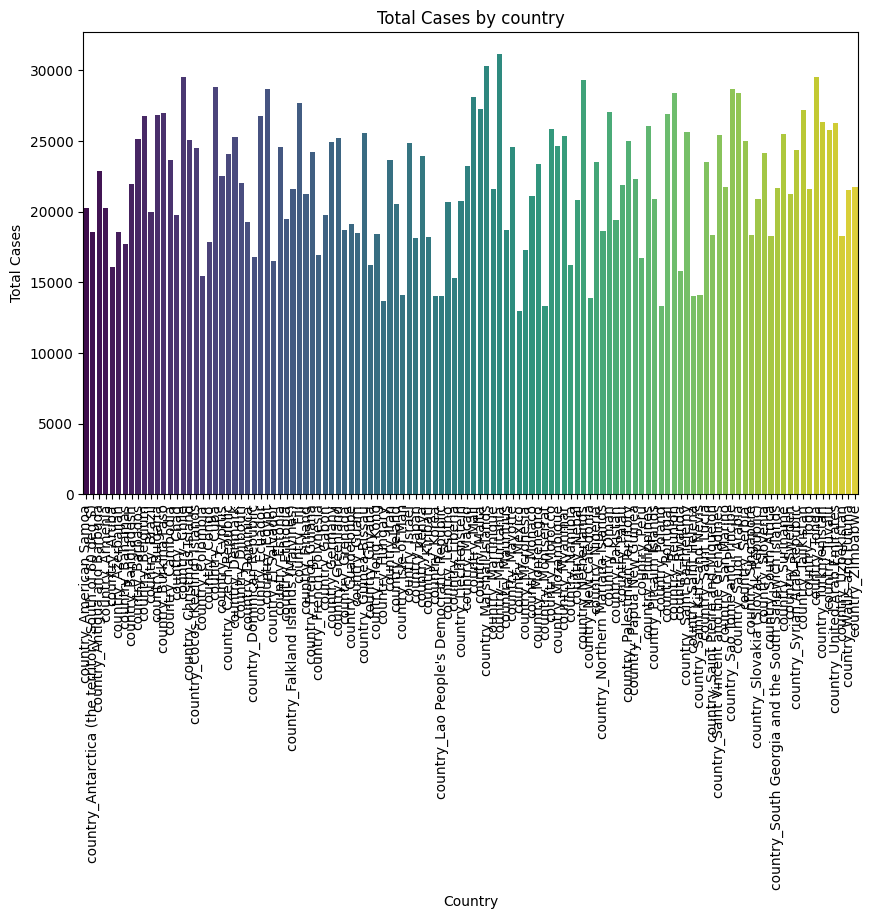

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Country', y='Total Cases', data=country_cases, palette='viridis')
plt.title('Total Cases by country')
plt.xlabel('Country')
plt.ylabel('Total Cases')
plt.xticks(rotation=90)
plt.show()

/tmp/ipython-input-34-4050754346.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Region', y='Total Cases', data=region_cases, palette='viridis')


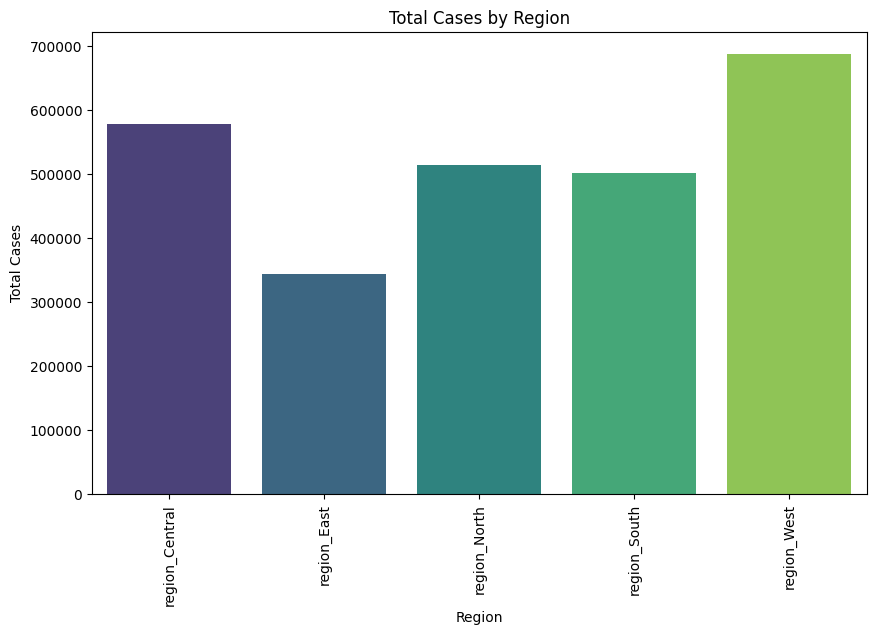

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Total Cases', data=region_cases, palette='viridis')
plt.title('Total Cases by Region')
plt.xlabel('Region')
plt.ylabel('Total Cases')
plt.xticks(rotation=90)
plt.show()

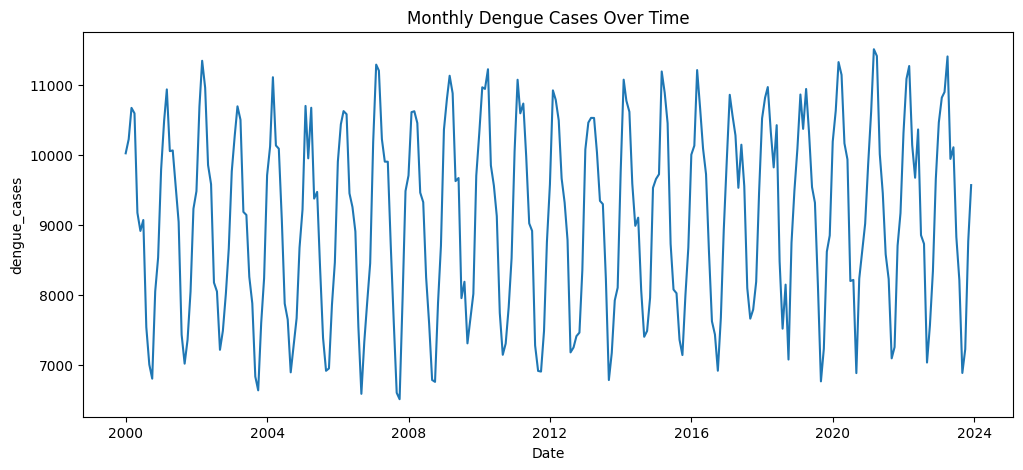

In [15]:
monthly = df.groupby(['year', 'month'])['dengue_cases'].sum().reset_index()
monthly['Date'] = pd.to_datetime(monthly[['year', 'month']].assign(DAY=1))

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly, x='Date', y='dengue_cases')
plt.title("Monthly Dengue Cases Over Time")
plt.show()

## **FEATURE ENGINEERING**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # ideal line
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Actual vs Predicted Cases")
plt.grid(True)
plt.show()

NameError: name 'y_test' is not defined

<Figure size 800x600 with 0 Axes>

## **COMPARE PROVINCE CASES TO FACTORS**

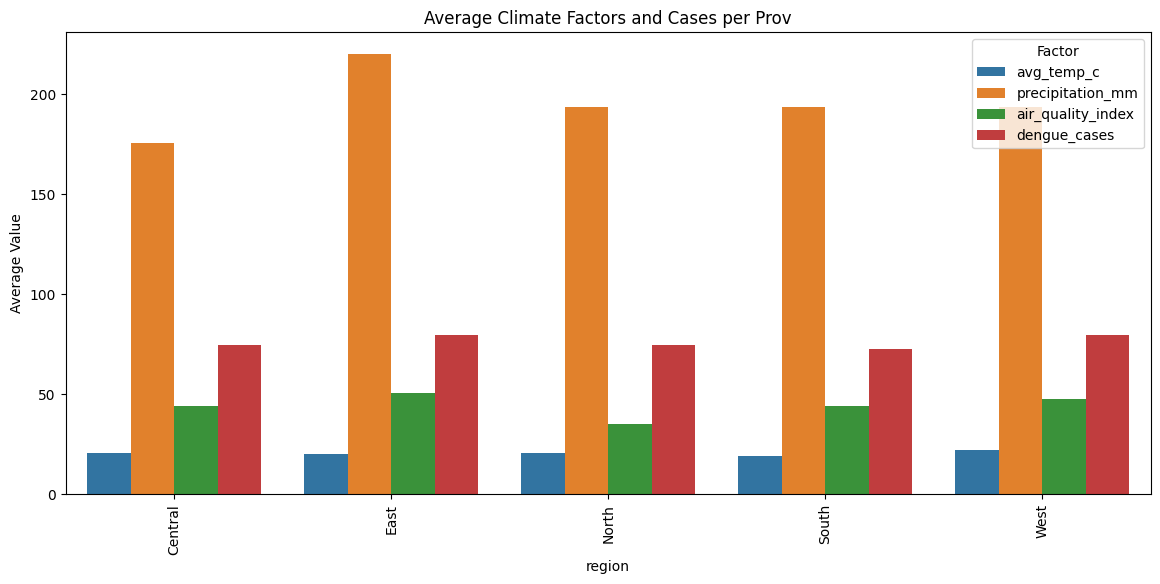

In [16]:
df['region'] = df[region_columns].idxmax(axis=1).str.replace('region_', '')
factors = df.groupby('region')[['avg_temp_c', 'precipitation_mm', 'air_quality_index', 'dengue_cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='region', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='region', y='Average Value', hue='Factor', palette='tab10')
plt.title('Average Climate Factors and Cases per Prov')
plt.xticks(rotation=90)
plt.show()

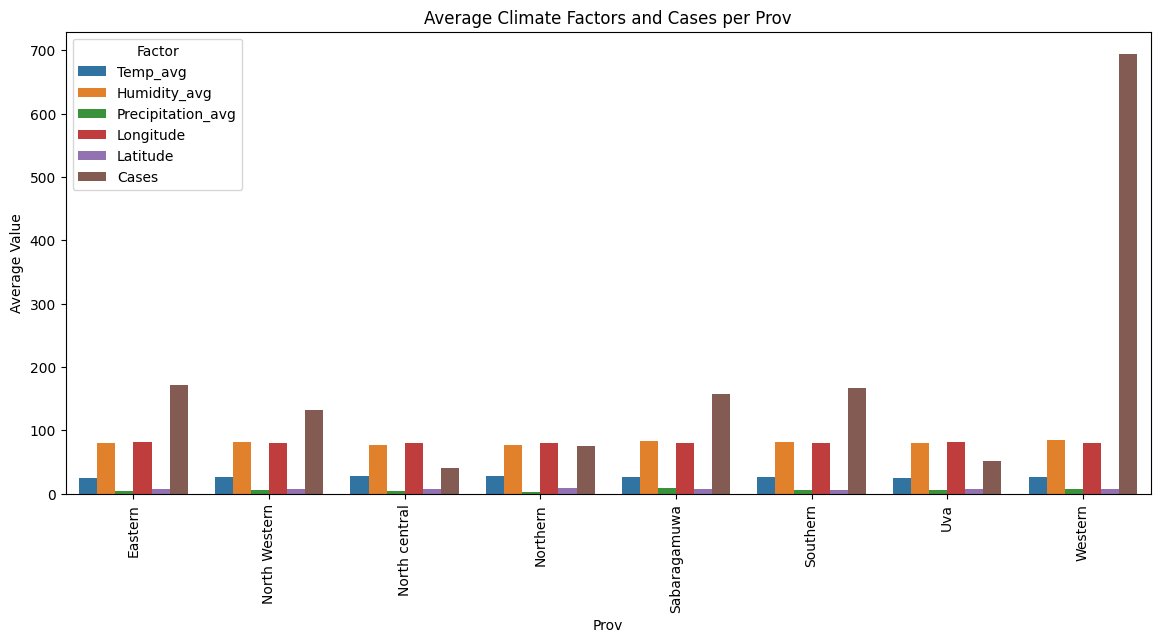

In [ ]:
df['Prov'] = df[province_columns].idxmax(axis=1).str.replace('Province_', '')
factors = df.groupby('Prov')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Longitude', 'Latitude', 'Cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='Prov', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Prov', y='Average Value', hue='Factor', palette='tab10')
plt.title('Average Climate Factors and Cases per Prov')
plt.xticks(rotation=90)
plt.show()

### **COMPARE DISTRICT CASES TO FACTORS**

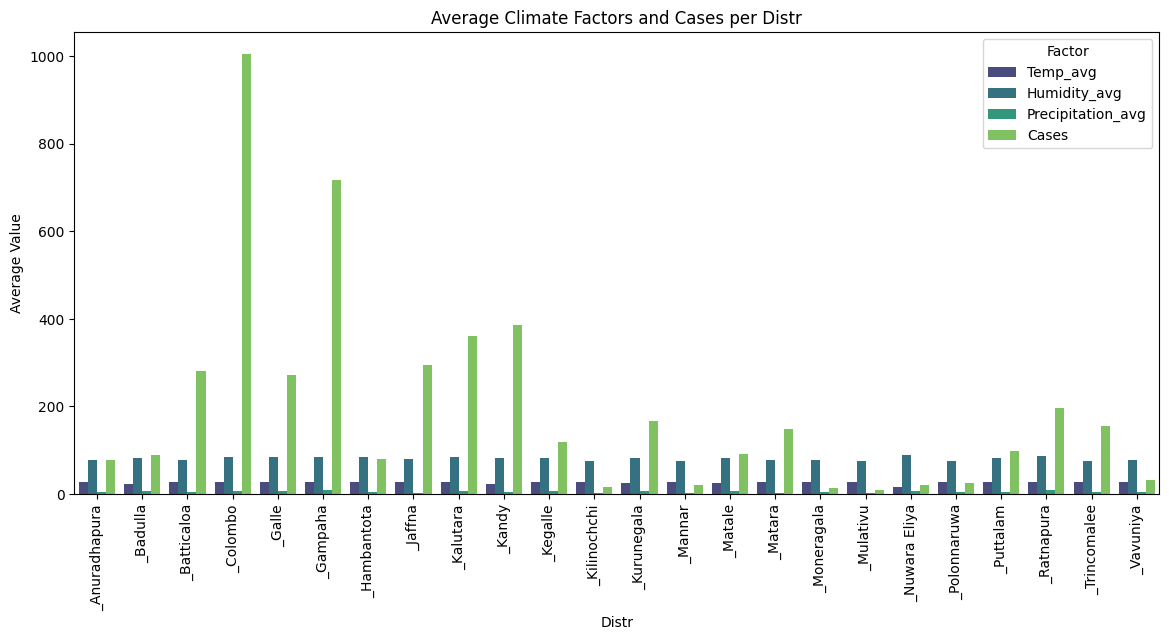

In [ ]:
df['Distr'] = df[district_columns].idxmax(axis=1).str.replace('District', '')
factors = df.groupby('Distr')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='Distr', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Distr', y='Average Value', hue='Factor', palette='viridis')
plt.title('Average Climate Factors and Cases per Distr')
plt.xticks(rotation=90)
plt.show()

### **CORRELATION HEATMAP**

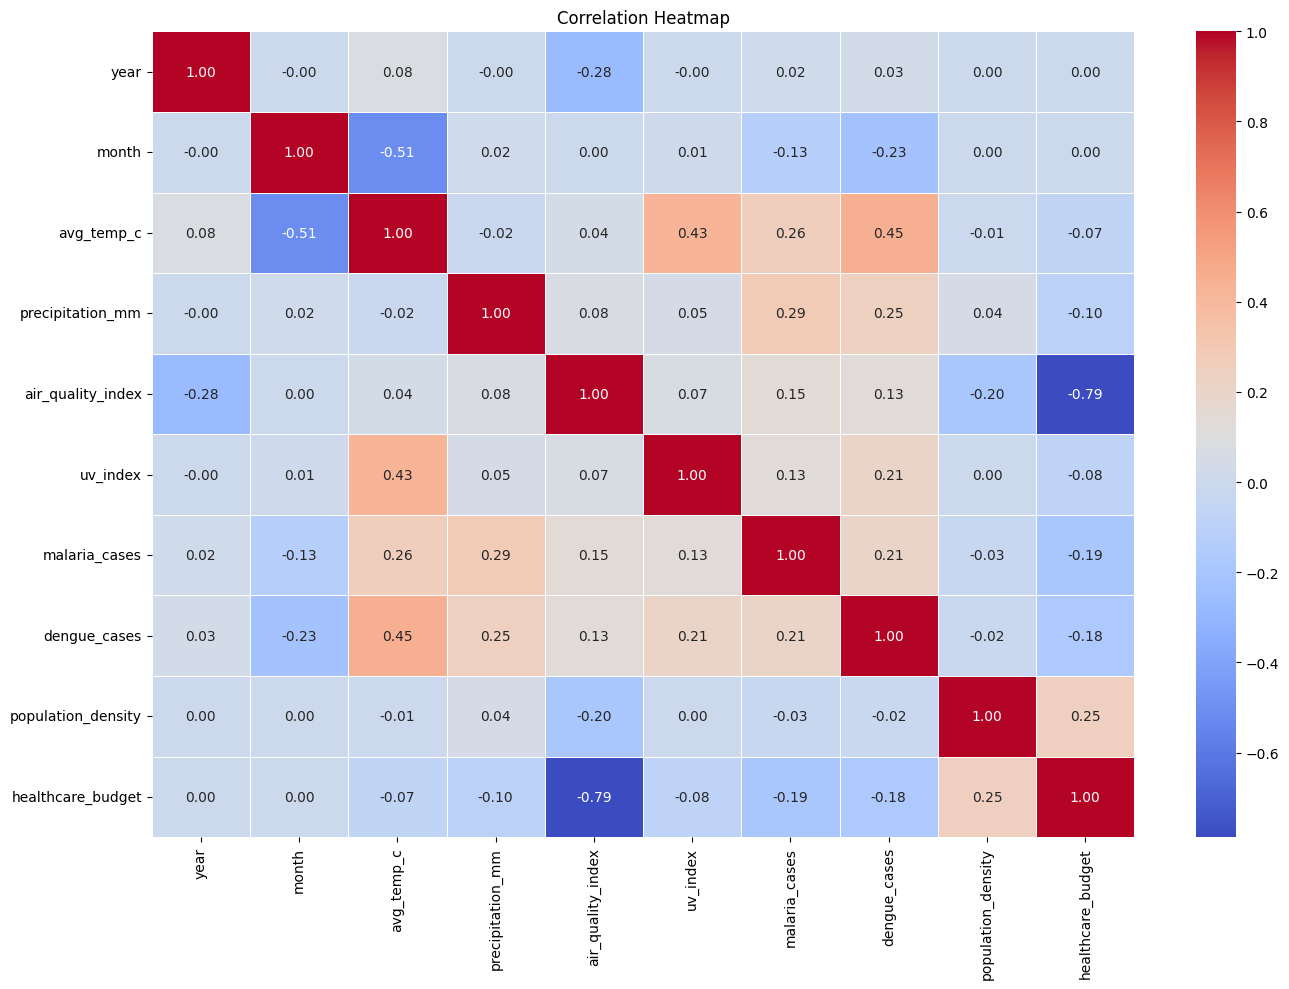

In [36]:
df_corr = df.copy()
df_corr = pd.get_dummies(df_corr, drop_first=True)
df_corr = df_corr.select_dtypes(include='number')  # Keep only numeric columns

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

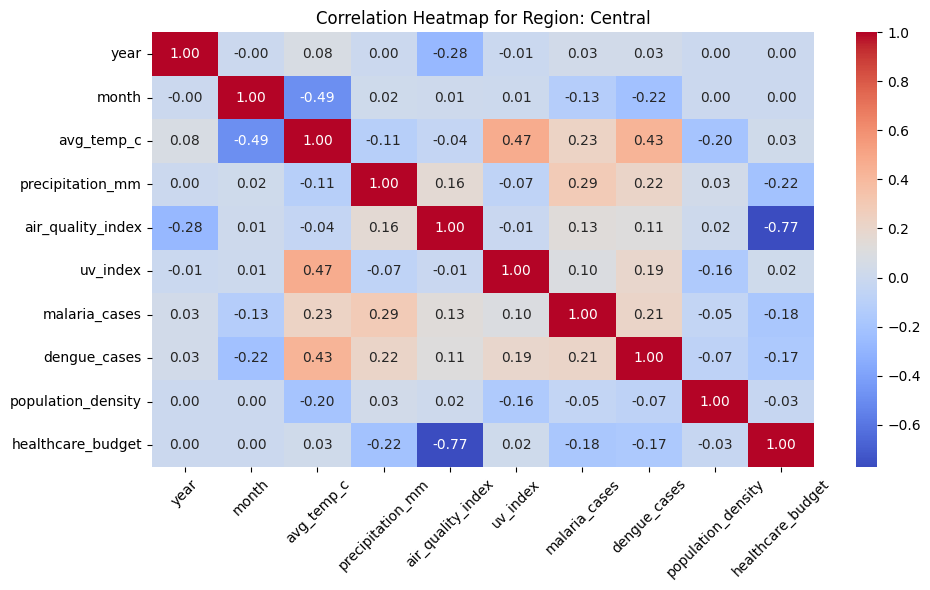

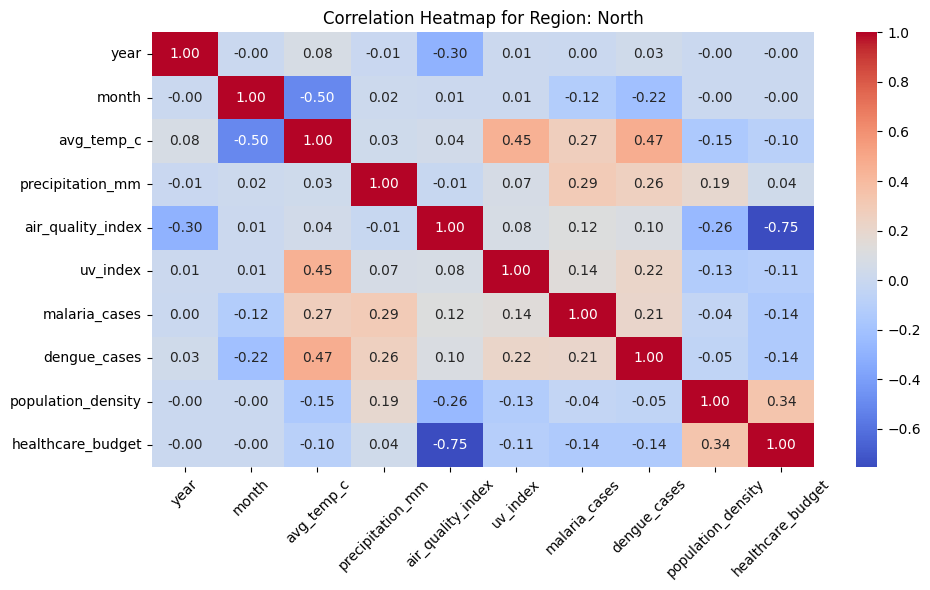

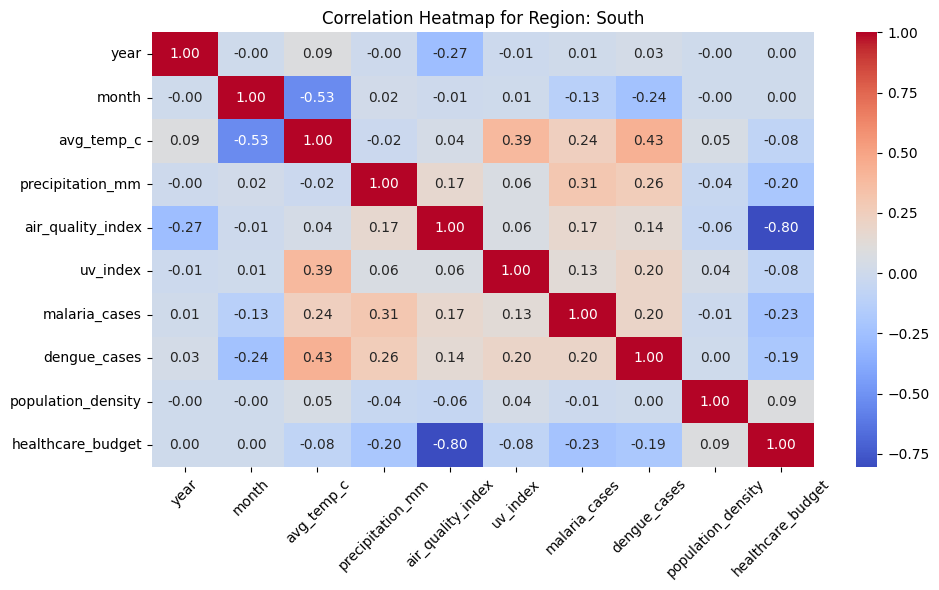

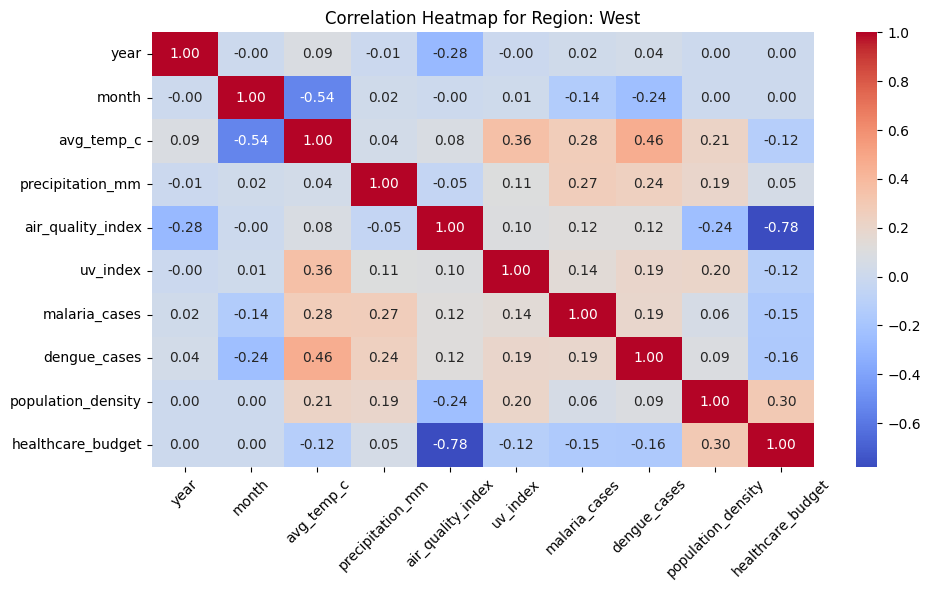

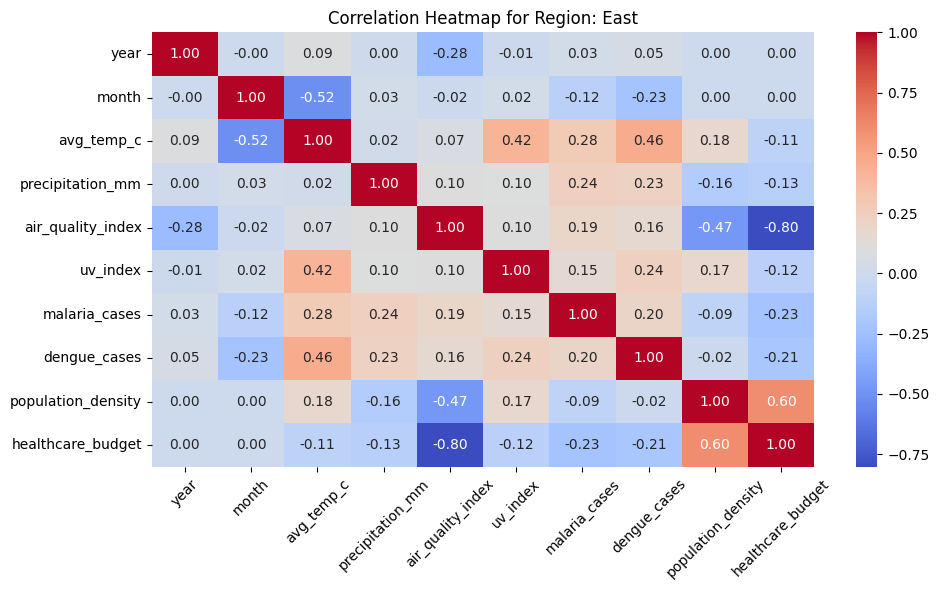

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure 'region' exists in your dataframe
if 'region' in df.columns:

    regions = df['region'].unique()

    for region in regions:
        region_df = df[df['region'] == region]

        # Optional: drop non-numeric columns
        numeric_cols = region_df.select_dtypes(include=['float64', 'int64'])

        # Compute correlation matrix
        corr_matrix = numeric_cols.corr()

        # Plot heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
        plt.title(f'Correlation Heatmap for Region: {region}')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

else:
    print("The column 'region' is not found in the dataframe.")

In [37]:
import pandas as pd
import statsmodels.api as sm

# 1. Select your predictor and target
X = df[['avg_temp_c']]  # Predictor: average temperature
y = df['dengue_cases']  # Target: dengue cases

# 2. Add a constant term for the intercept
X = sm.add_constant(X)

# 3. Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X).fit()

# 4. Print the summary for p-value, R-squared, etc.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           dengue_cases   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     8837.
Date:                Mon, 14 Jul 2025   Prob (F-statistic):               0.00
Time:                        13:52:33   Log-Likelihood:            -1.7020e+05
No. Observations:               34560   AIC:                         3.404e+05
Df Residuals:                   34558   BIC:                         3.404e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.0995      0.470     74.687      0.0

Results above for p value is <0.05 so temperature is a factor

### **----------START MODELLING-----------**

### **FEATURE IMPORTANCE**


In [35]:
X = df.drop(columns=["dengue_cases"])
Y = df["dengue_cases"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

NameError: name 'y' is not defined

### **RANDOM FOREST**

In [55]:
regions = [ col for col in df.columns if col.startswith('region_')]
# df['temp_precip_interaction'] = df['avg_temp_c'] * df['precipitation_mm']
# df['air_quality_temp_interaction'] = df['air_quality_index'] * df['avg_temp_c']
# df['uv_precip_interaction'] = df['uv_index'] * df['precipitation_mm']
# df['env_stress_score'] = df['precipitation_mm'] * df['air_quality_index'] * df['uv_index']

features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features] = scaler.fit_transform(X_train[features])
X_test_scaled[features] = scaler.transform(X_test[features])

# X = df[features]
# Y = df['dengue_cases']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

R-squared: 0.2612095892096892
Mean Squared Error: 1056.9933900752314


In [47]:
# Convert 'year' and 'month' to 'ds' datetime
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# --- One-Hot Encode 'country' and 'region' ---
df_encoded = pd.get_dummies(df, columns=['country', 'region'], prefix=['country', 'region'])


# --- 2. Feature Engineering ---

print("\nPerforming feature engineering...")

# Identify all one-hot encoded columns (country_X and region_Y)
location_cols = [col for col in df_encoded.columns if col.startswith('country_') or col.startswith('region_')]

# Create a unique identifier for each location combination
# This string combination serves as the perfect grouping key for lagging
df_encoded['location_id'] = df_encoded[location_cols].astype(str).agg(''.join, axis=1)

# --- IMPROVED SORTING ---
# Sort by the unique location identifier first, then by date.
# This ensures that all data points for a specific country/region are grouped together
# and ordered chronologically, which is essential for accurate lagging.
df_encoded = df_encoded.sort_values(by=['location_id', 'ds']).reset_index(drop=True)
print("DataFrame sorted by location_id and ds.")

# 2.1. Add 'month' feature
df_encoded['month'] = df_encoded['ds'].dt.month

# 2.2. Add Lagged Dengue Cases (y)
df_encoded['dengue_cases_lag1'] = df_encoded.groupby('location_id')['dengue_cases'].shift(1)
df_encoded['dengue_cases_lag2'] = df_encoded.groupby('location_id')['dengue_cases'].shift(2)
df_encoded['dengue_cases_lag3'] = df_encoded.groupby('location_id')['dengue_cases'].shift(3)
df_encoded['dengue_cases_lag4'] = df_encoded.groupby('location_id')['dengue_cases'].shift(4)
df_encoded['dengue_cases_lag5'] = df_encoded.groupby('location_id')['dengue_cases'].shift(5)
df_encoded['dengue_cases_lag6'] = df_encoded.groupby('location_id')['dengue_cases'].shift(6)



# 2.3. Add Lagged Environmental Features
df_encoded['avg_temp_c_lag1'] = df_encoded.groupby('location_id')['avg_temp_c'].shift(1)
df_encoded['precipitation_mm_lag1'] = df_encoded.groupby('location_id')['precipitation_mm'].shift(1)

# Drop the temporary location_id column as it's no longer needed for features
df_encoded.drop(columns=['location_id'], inplace=True)


# --- Handle NaNs created by lagging ---
newly_lagged_features = ['dengue_cases_lag1', 'dengue_cases_lag2', 'dengue_cases_lag3', 'dengue_cases_lag4',
                         'dengue_cases_lag5', 'dengue_cases_lag6','avg_temp_c_lag1', 'precipitation_mm_lag1']

for col in newly_lagged_features:
    if col in df_encoded.columns and df_encoded[col].isnull().any():
        df_encoded[col].fillna(df_encoded[col].mean(), inplace=True)
        print(f"Filled NaNs in '{col}' with mean.")

# Also ensure original numeric columns have no NaNs (from previous steps if not handled)
original_numeric_features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
                             'uv_index', 'malaria_cases', 'population_density', 'healthcare_budget']
for col in original_numeric_features:
    if col in df_encoded.columns and df_encoded[col].isnull().any():
        df_encoded[col].fillna(df_encoded[col].mean(), inplace=True)
        print(f"Filled NaNs in original feature '{col}' with mean.")


print("Feature engineering complete.")
print(f"DataFrame head after feature engineering:\n{df_encoded.head()}")
print(f"DataFrame info after feature engineering:\n{df_encoded.info()}")


# --- Define Features and Target for Model ---
# Rename 'dengue_cases' to 'y'
df_encoded = df_encoded.rename(columns={'dengue_cases': 'y'})


# Dynamically collect all one-hot encoded country and region columns
regions = [col for col in df_encoded.columns if col.startswith('country_') or col.startswith('region_')]

# Update features list to include new engineered features
features = [
    'avg_temp_c', 'precipitation_mm', 'air_quality_index',
    'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget',
    'month', # New feature
    'dengue_cases_lag1', 'dengue_cases_lag2', # New lagged target features
    'avg_temp_c_lag1', 'precipitation_mm_lag1', # New lagged regressor features
    *regions # All one-hot encoded regions and countries
]

# Filter features to only include those that actually exist in the DataFrame
final_features = [f for f in features if f in df_encoded.columns]
print(f"\nFinal features used for the model: {final_features}")


X = df_encoded[final_features]
y = df_encoded['y']

# --- Model Training and Evaluation (using chronological split) ---
print("\nTraining and evaluating Random Forest Regressor...")

# Split data chronologically to prevent data leakage in time series
# Use 80% for training, 20% for testing
split_point = int(len(df_encoded) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"\nResults with Improved Feature Engineering (Dynamic Sorting):")
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

print("\nScript execution complete.")


Performing feature engineering...
DataFrame sorted by location_id and ds.


/tmp/ipython-input-47-986959320.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[col].fillna(df_encoded[col].mean(), inplace=True)


Filled NaNs in 'dengue_cases_lag1' with mean.
Filled NaNs in 'dengue_cases_lag2' with mean.
Filled NaNs in 'dengue_cases_lag3' with mean.
Filled NaNs in 'dengue_cases_lag4' with mean.
Filled NaNs in 'dengue_cases_lag5' with mean.
Filled NaNs in 'dengue_cases_lag6' with mean.
Filled NaNs in 'avg_temp_c_lag1' with mean.
Filled NaNs in 'precipitation_mm_lag1' with mean.
Feature engineering complete.
DataFrame head after feature engineering:
   year  month  avg_temp_c  precipitation_mm  air_quality_index  uv_index  \
0  2000      1      19.595            86.205             64.297     7.063   
1  2000      2      25.173           137.920              0.000     9.963   
2  2000      3      21.151           111.619              0.000    10.142   
3  2000      4      19.282           145.835              9.945     9.272   
4  2000      5      16.971           278.976              0.000     8.319   

   malaria_cases  dengue_cases  population_density  healthcare_budget  ...  \
0             58 

In [ ]:
df = df.sort_values(by=['country', 'region', 'year', 'month']).reset_index(drop=True)

# ---- Create Lagged Features ----
df['dengue_cases_lag1'] = df['dengue_cases'].shift(1)
df['avg_temp_c_lag1'] = df['avg_temp_c'].shift(1)
df['precipitation_mm_lag1'] = df['precipitation_mm'].shift(1)
df['malaria_cases_lag1'] = df['malaria_cases'].shift(1)

# ---- Drop rows with NaNs from lagging (usually first row) ----
df = df.dropna().reset_index(drop=True)

# ---- Create Feature Interactions ----
df['temp_precip_interaction'] = df['avg_temp_c'] * df['precipitation_mm']
df['malaria_dengue_lag_interaction'] = df['malaria_cases_lag1'] * df['dengue_cases_lag1']
df['air_quality_temp_interaction'] = df['air_quality_index'] * df['avg_temp_c']
df['uv_precip_interaction'] = df['uv_index'] * df['precipitation_mm']
df['healthcare_burden_index'] = df['population_density'] / (df['healthcare_budget'] + 1)
df['env_stress_score'] = df['precipitation_mm'] * df['air_quality_index'] * df['uv_index']

# ---- Define Region Columns ----
regions = [col for col in df.columns if col.startswith('region_')]

# ---- Final Feature List ----
features = [
    'avg_temp_c', 'precipitation_mm', 'air_quality_index', 'malaria_cases',
    'year', 'uv_index', 'population_density', 'healthcare_budget',
    'dengue_cases_lag1', 'avg_temp_c_lag1', 'precipitation_mm_lag1', 'malaria_cases_lag1',
    'temp_precip_interaction', 'malaria_dengue_lag_interaction',
    'air_quality_temp_interaction', 'uv_precip_interaction',
    'healthcare_burden_index', 'env_stress_score', *regions
]

# ---- Train-Test Split: Time-aware ----
split_index = int(0.8 * len(df))
X = df[features]
y = df['dengue_cases']
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

# ---- Model Training ----
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ---- Predictions and Evaluation ----
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")


R-squared: 0.1835221776022079
Mean Squared Error: 1068.7447986689815


### **LGBM**

In [36]:
regions = [ col for col in df.columns if col.startswith('region_')]
# df['temp_precip_interaction'] = df['avg_temp_c'] * df['precipitation_mm']
# df['air_quality_temp_interaction'] = df['air_quality_index'] * df['avg_temp_c']
# df['uv_precip_interaction'] = df['uv_index'] * df['precipitation_mm']
# df['env_stress_score'] = df['precipitation_mm'] * df['air_quality_index'] * df['uv_index']

features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features] = scaler.fit_transform(X_train[features])
X_test_scaled[features] = scaler.transform(X_test[features])

# X = df[features]
# Y = df['dengue_cases']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 27648, number of used features: 136
[LightGBM] [Info] Start training from score 76.002242
R-squared: 0.2694761046107158
Mean Squared Error: 1045.1664199220952


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1477
[LightGBM] [Info] Number of data points in the train set: 27648, number of used features: 13
[LightGBM] [Info] Start training from score 76.002242
Model Performance:
R-squared: 0.2786
Mean Squared Error: 1032.1410
Root Mean Squared Error: 32.1270

Top 10 Most Important Features:
               feature  importance
1     precipitation_mm         542
0           avg_temp_c         535
3        malaria_cases         410
7    healthcare_budget         350
2    air_quality_index         349
5             uv_index         312
4                 year         252
6   population_density         192
12         region_West          17
11        region_South          17


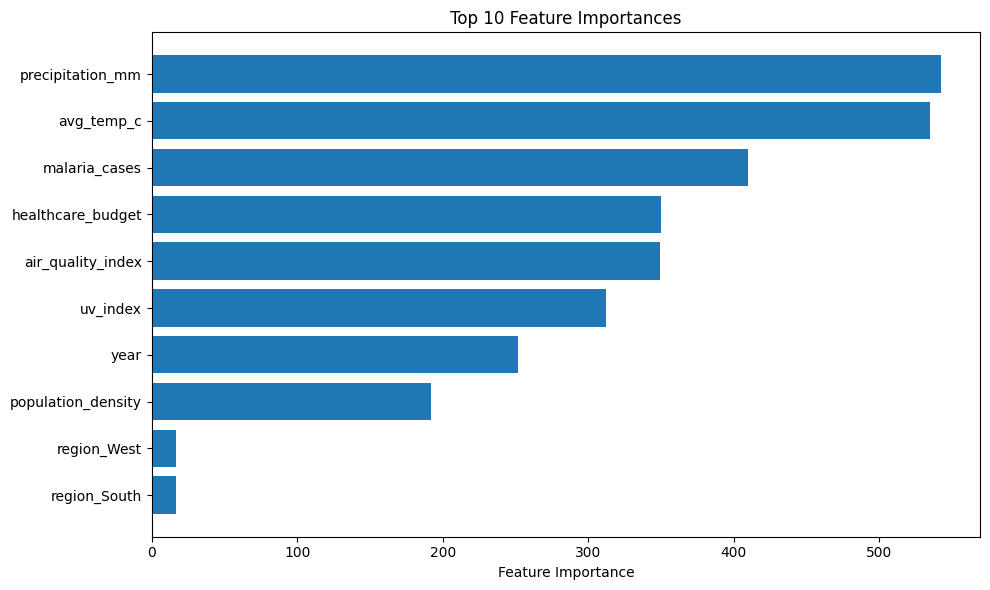

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor

# Assuming df is your dataframe with dengue data
# Load your data here: df = pd.read_csv('your_data.csv')

# Extract region columns
regions = [col for col in df.columns if col.startswith('region_')]

# Define features for the model
features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
           'malaria_cases', 'year', 'uv_index', 'population_density',
           'healthcare_budget'] + regions  # Include region columns

# Prepare features and target
X = df[features]
y = df['dengue_cases']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale only the numeric features (not the region dummy variables)
numeric_features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
                   'malaria_cases', 'year', 'uv_index', 'population_density',
                   'healthcare_budget']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only numeric features
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# Train the model
model = LGBMRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Model Performance:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Optional: Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### **GRADIENT BOOSTING REGRESSOR**

In [39]:
regions = [ col for col in df.columns if col.startswith('region_')]
features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget',*regions]
X = df[features]
Y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error:  {mae}")

R-squared: 0.2865120440886505
Mean Squared Error: 1020.7929641233985
Mean Absolute Error:  27.702305015540755


### **XG BOOST**

In [ ]:
features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget',*regions]
X = df[features]
Y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

R-squared: 0.23324722051620483
Mean Squared Error: 1071.5201416015625


### **FACEBOOK PROPHET**

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6vcoui8g/4rp23ybd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6vcoui8g/99b52aak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13922', 'data', 'file=/tmp/tmp6vcoui8g/4rp23ybd.json', 'init=/tmp/tmp6vcoui8g/99b52aak.json', 'output', 'file=/tmp/tmp6vcoui8g/prophet_modelgrk_ug59/prophet_model-20250708205554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   yhat  yhat_lower  yhat_upper
292 2024-08-01 72.217      26.282     114.986
293 2024-09-01 69.428      25.690     118.974
294 2024-10-01 69.627      24.875     114.625
295 2024-11-01 73.950      31.888     118.751
296 2024-12-01 82.007      35.409     127.623


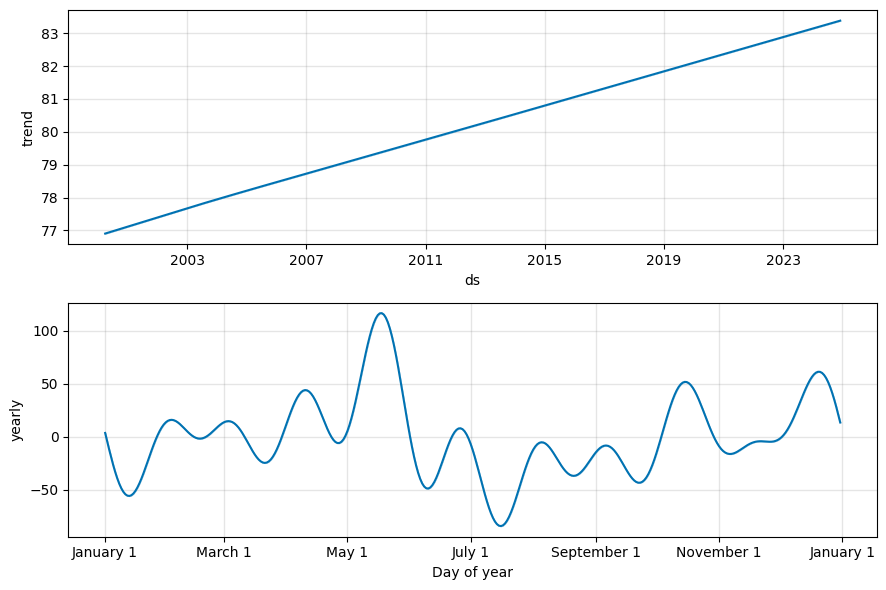

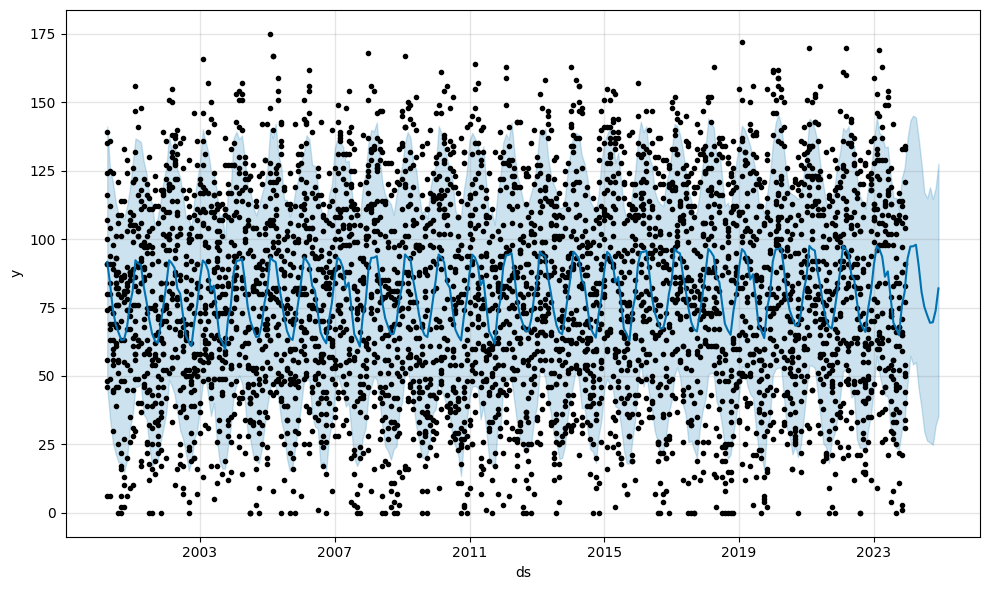

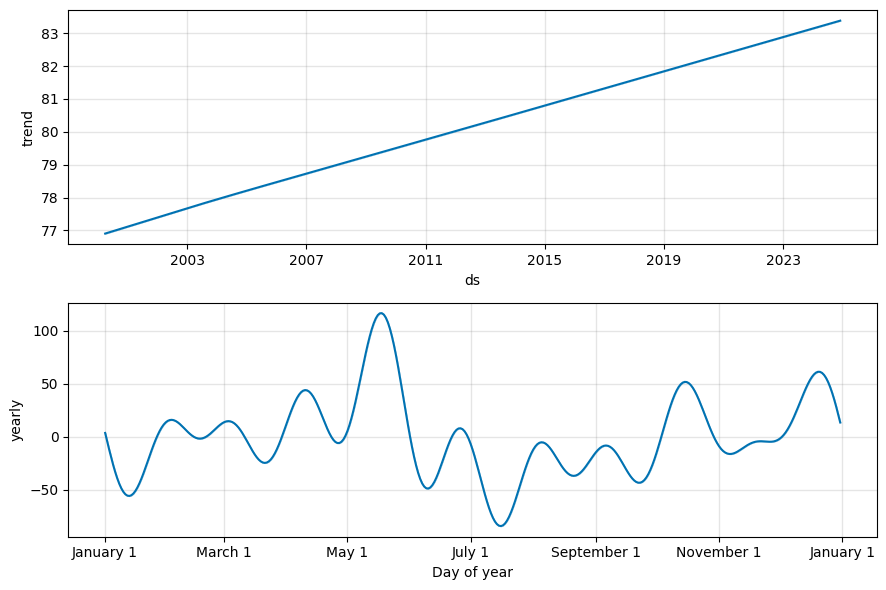

In [ ]:
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values(by='ds')

regions = [col for col in df.columns if col.startswith('region_')]
df_prophet = df[['ds', 'dengue_cases', 'country'] + regions].copy()
df_prophet = df_prophet.rename(columns={'dengue_cases': 'y'})

region_df = df_prophet[df_prophet['region_East'] == True].dropna(subset=['y'])


model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(region_df)

future = model.make_future_dataframe(periods=12, freq='MS')

forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

model.plot(forecast)
model.plot_components(forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4pmtlvss/e931jw9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4pmtlvss/mava2g7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43218', 'data', 'file=/tmp/tmp4pmtlvss/e931jw9_.json', 'init=/tmp/tmp4pmtlvss/mava2g7i.json', 'output', 'file=/tmp/tmp4pmtlvss/prophet_modelv44t7inw/prophet_model-20250709222331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:23:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


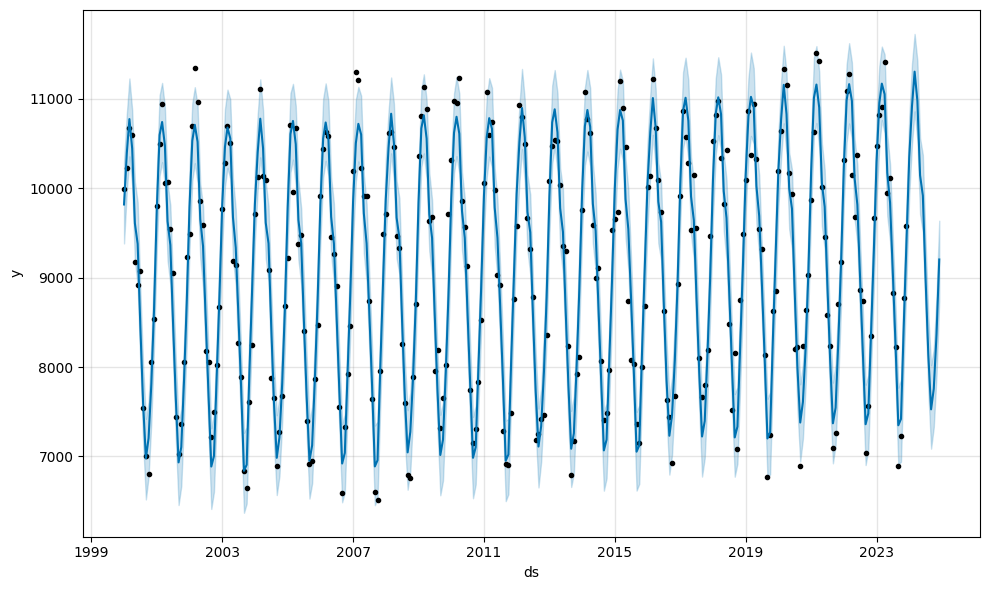

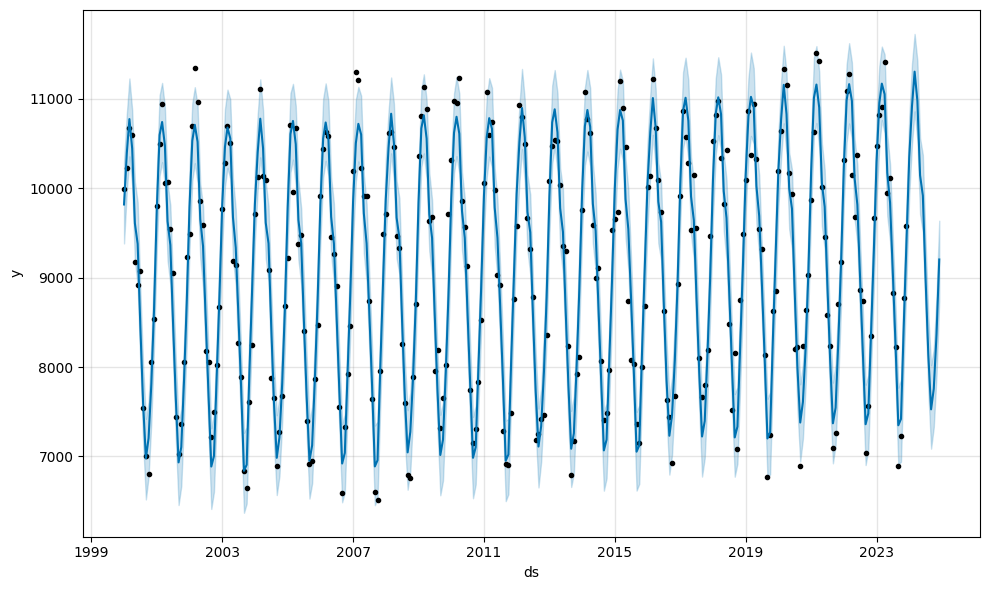

In [ ]:
# Prepare time series data
df_prophet = df.groupby(['year', 'month'])['dengue_cases'].sum().reset_index()
df_prophet['ds'] = pd.to_datetime(df_prophet[['year', 'month']].assign(day=1))
df_prophet['y'] = df_prophet['dengue_cases']
df_prophet = df_prophet[['ds', 'y']]

# Fit the model
model = Prophet()
model.fit(df_prophet)

# Create future dataframe (e.g., 12 months ahead)
future = model.make_future_dataframe(periods=12, freq='MS')

# Predict
forecast = model.predict(future)

# Plot
model.plot(forecast)



Initializing and training Prophet model...
Model training complete.

Generating future predictions...
Forecast generated.

Plotting forecast...


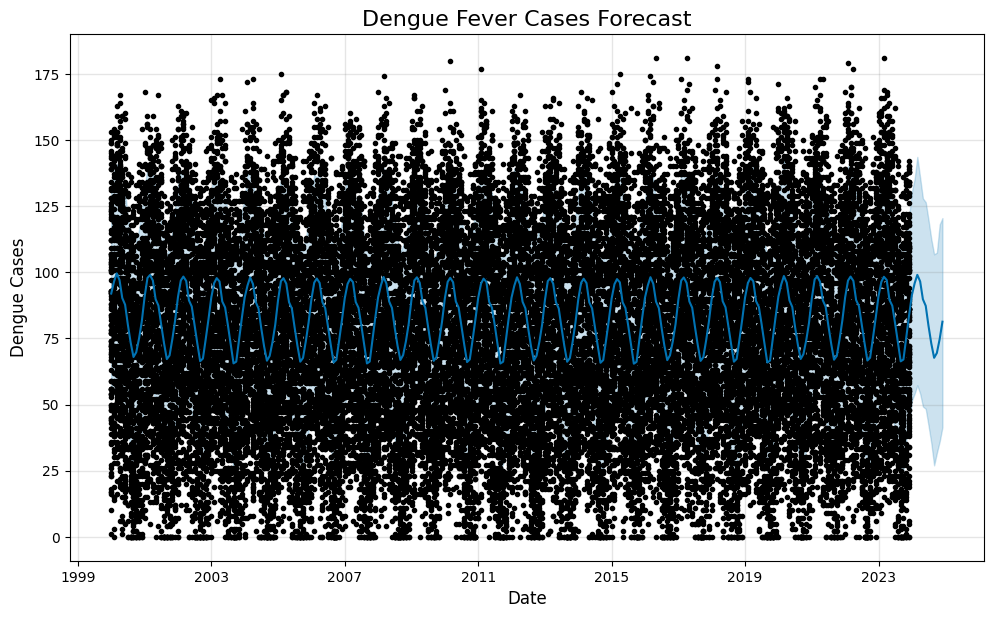

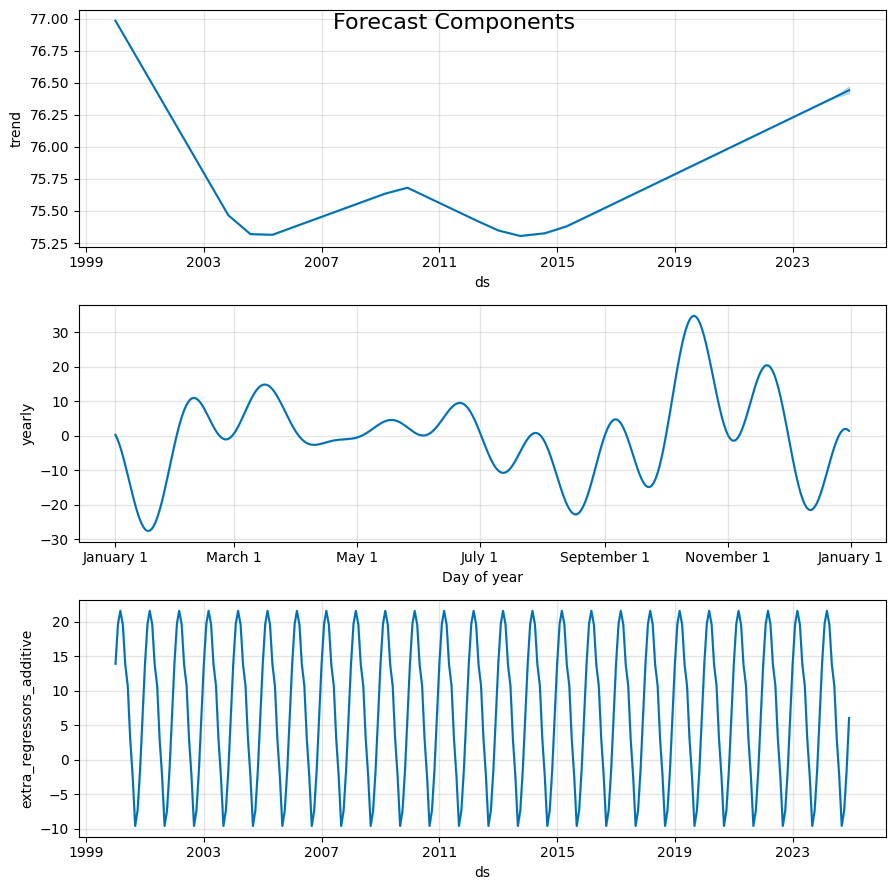


Future Dengue Cases Forecast (Last 12 Months):
        ds   yhat  yhat_lower  yhat_upper
2024-01-01 91.288      51.498     130.375
2024-02-01 95.869      54.155     135.340
2024-03-01 99.010      57.257     143.595
2024-04-01 96.521      54.097     135.701
2024-05-01 89.784      49.261     127.923
2024-06-01 87.309      48.366     126.475
2024-07-01 79.834      42.155     119.891
2024-08-01 73.041      35.431     112.535
2024-09-01 67.655      26.989     106.763
2024-10-01 69.480      31.736     107.403
2024-11-01 74.767      36.058     118.068
2024-12-01 81.303      41.451     120.472

Script execution complete.


In [ ]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

df = df.rename(columns={'dengue_cases': 'y'})

prophet_df = df[['ds', 'y', 'avg_temp_c', 'precipitation_mm',
                 'air_quality_index', 'uv_index', 'malaria_cases',
                 'population_density', 'healthcare_budget']].copy()

for col in ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'uv_index', 'malaria_cases', 'population_density', 'healthcare_budget']:
    prophet_df[col] = pd.to_numeric(prophet_df[col], errors='coerce')

    if prophet_df[col].isnull().any():
        prophet_df[col] = prophet_df[col].fillna(prophet_df[col].mean())
        print(f"Warning: NaNs found and filled in column '{col}'.")



print("\nInitializing and training Prophet model...")
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)


regressors = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
              'uv_index', 'malaria_cases', 'population_density', 'healthcare_budget']
for col in regressors:
    m.add_regressor(col)

m.fit(prophet_df)
print("Model training complete.")

print("\nGenerating future predictions...")

future_periods = 12
future = m.make_future_dataframe(periods=future_periods, freq='MS')

last_known_values = prophet_df[regressors].iloc[-1].to_dict()
for col in regressors:
    if col not in ['avg_temp_c', 'precipitation_mm']:
        future[col] = future['ds'].apply(lambda x: last_known_values.get(col))

prophet_df['month'] = prophet_df['ds'].dt.month
monthly_averages = prophet_df.groupby('month')[['avg_temp_c', 'precipitation_mm']].mean().reset_index()

future['month'] = future['ds'].dt.month
for col in ['avg_temp_c', 'precipitation_mm']:
    future = pd.merge(future, monthly_averages[['month', col]], on='month', how='left', suffixes=('', '_avg_merged'))
    future[col] = future[f'{col}']

cols_to_drop = [f'{col}_avg_merged' for col in ['avg_temp_c', 'precipitation_mm']] + ['month']
future = future.drop(columns=cols_to_drop, errors='ignore')

for col in regressors:
    if col not in future.columns:
        future[col] = prophet_df[col].iloc[-1]
    future[col] = pd.to_numeric(future[col], errors='coerce').fillna(prophet_df[col].mean()) # Final NaN check

forecast = m.predict(future)
print("Forecast generated.")

print("\nPlotting forecast...")
fig1 = m.plot(forecast)
plt.title('Dengue Fever Cases Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Dengue Cases', fontsize=12)
plt.grid(True)
plt.show()

fig2 = m.plot_components(forecast)
plt.suptitle('Forecast Components', fontsize=16)
plt.show()

print("\nFuture Dengue Cases Forecast (Last 12 Months):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(future_periods).to_string(index=False))

print("\nScript execution complete.")

### **FORECAST PER FOR COUNTRY**


Initializing and training Prophet model...
Model training complete.

Generating future predictions...
Forecast generated.

Plotting forecast...


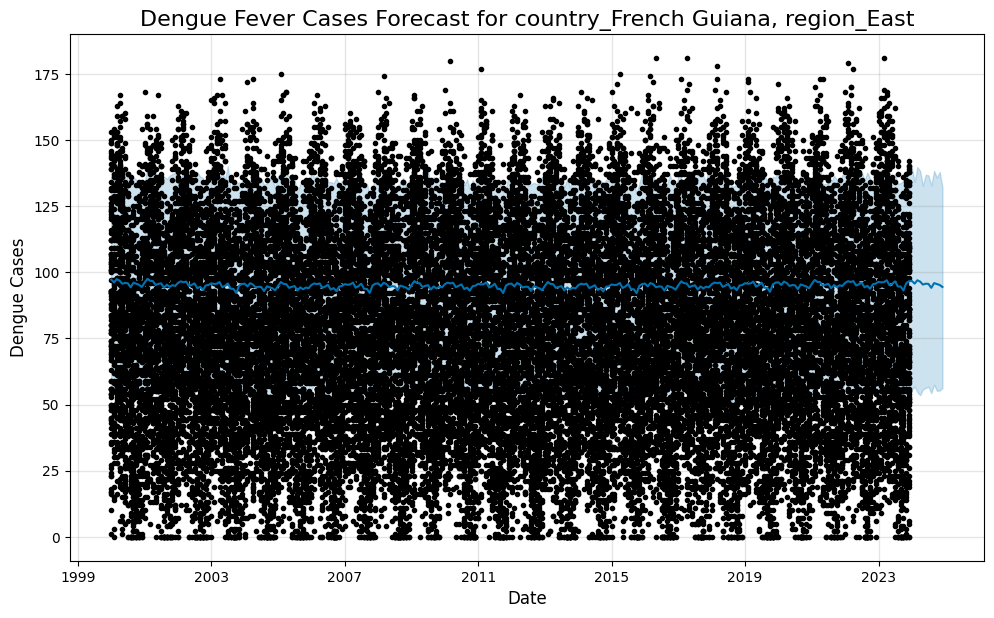

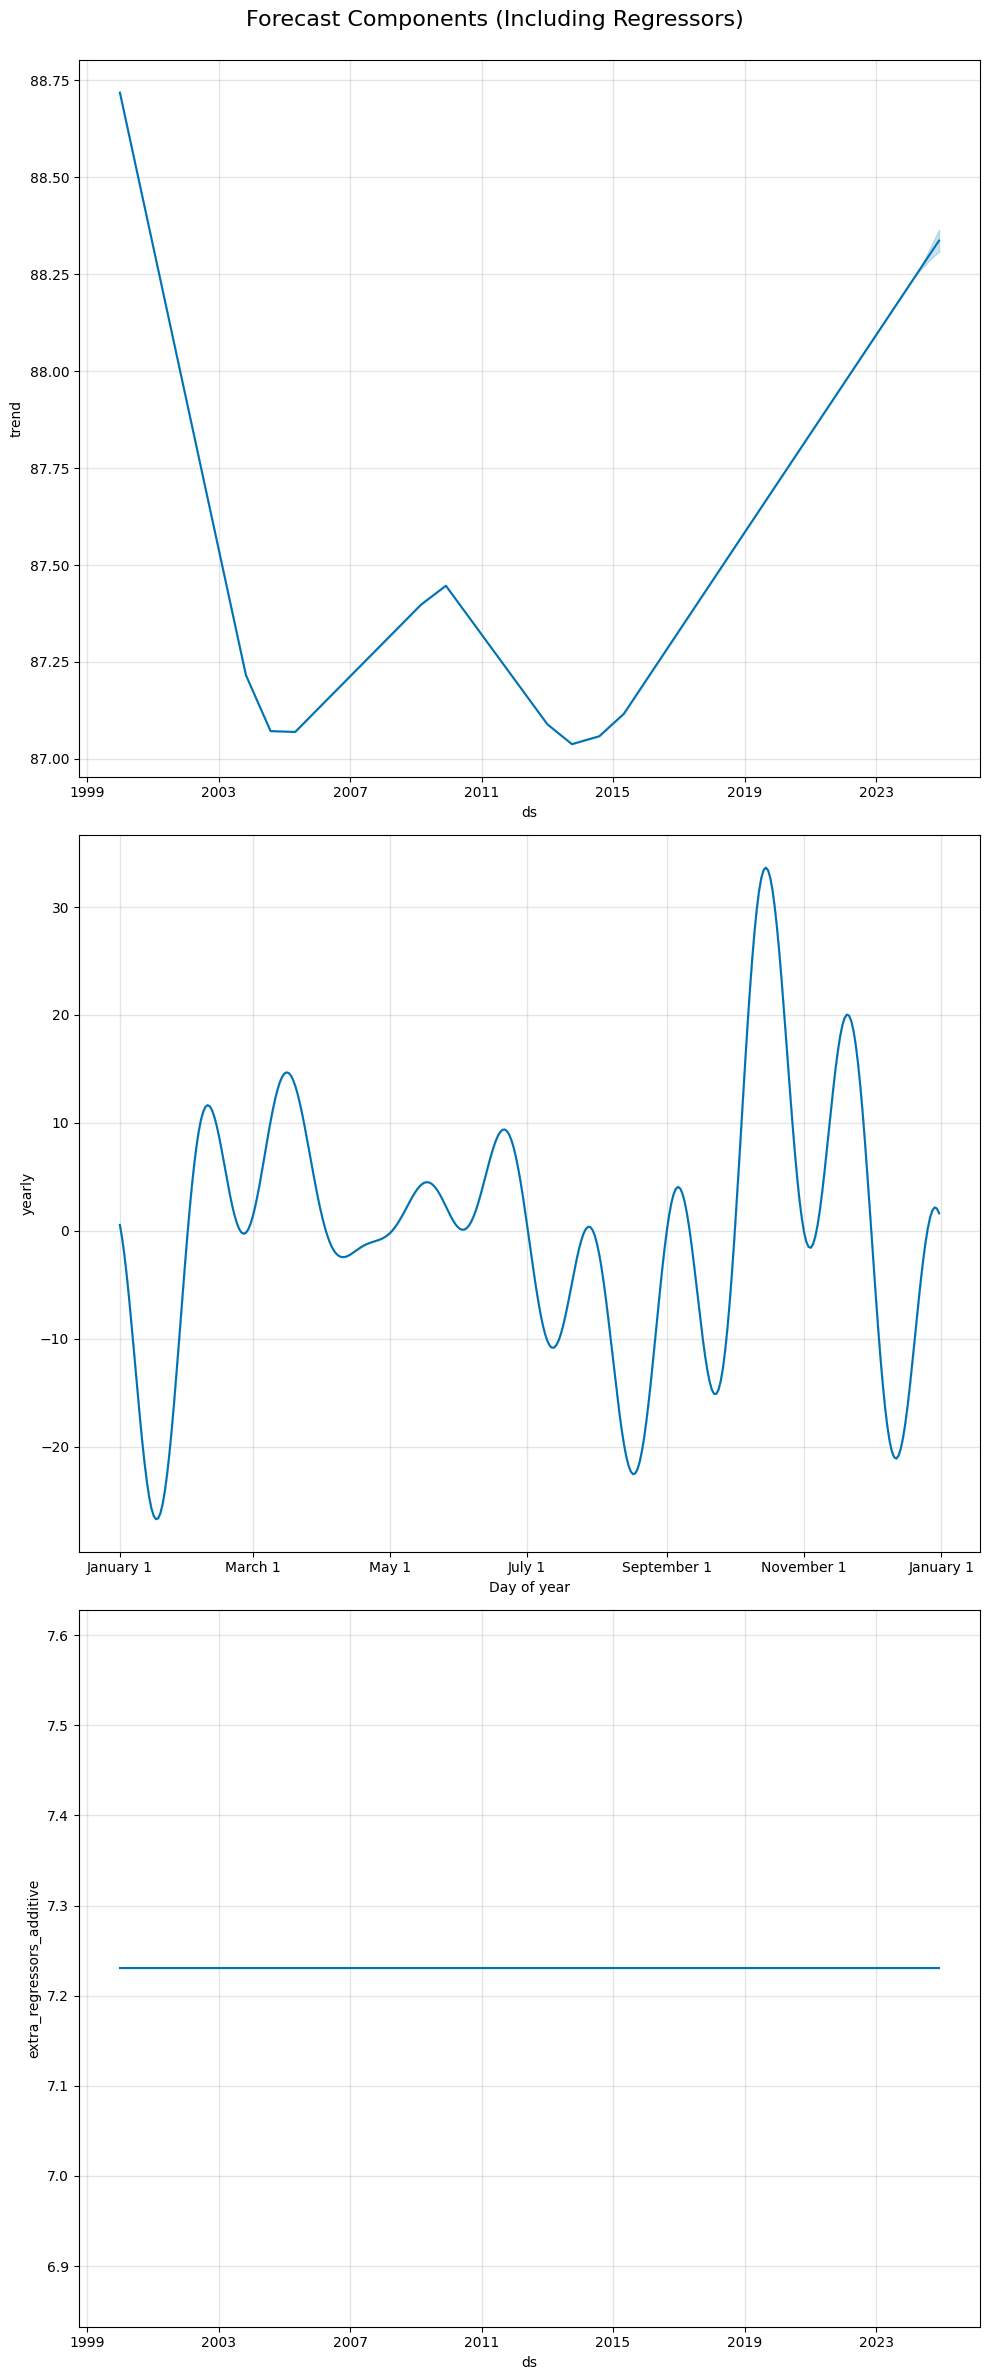


Future Dengue Cases Forecast for country_French Guiana, region_East (Next 12 Months):
        ds   yhat  yhat_lower  yhat_upper
2024-01-01 96.710      55.571     139.554
2024-02-01 95.687      56.751     134.170
2024-03-01 96.965      54.707     139.736
2024-04-01 96.452      53.512     138.295
2024-05-01 95.332      55.685     132.732
2024-06-01 95.666      56.245     136.844
2024-07-01 95.583      56.698     136.614
2024-08-01 94.104      54.290     132.834
2024-09-01 95.892      57.486     138.326
2024-10-01 95.546      55.189     135.771
2024-11-01 95.176      55.281     137.892
2024-12-01 94.419      56.223     132.145

Script execution complete.


In [ ]:
country_columns = [col for col in df.columns if col.startswith('country_')]
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

df = df.rename(columns={'dengue_cases': 'y'})

df_encoded = pd.get_dummies(df, columns=['country', 'region'], prefix=['country', 'region'])

original_regressors = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
                       'uv_index', 'malaria_cases', 'population_density', 'healthcare_budget']

encoded_regressor_cols = [col for col in df_encoded.columns if col.startswith('country_') or col.startswith('region_')]

all_regressors = original_regressors + encoded_regressor_cols

prophet_df = df_encoded[['ds', 'y'] + all_regressors].copy()

for col in all_regressors:
    prophet_df[col] = pd.to_numeric(prophet_df[col], errors='coerce')
    if prophet_df[col].isnull().any():
        if col in encoded_regressor_cols:
            prophet_df[col] = prophet_df[col].fillna(0)
        else:
            prophet_df[col] = prophet_df[col].fillna(prophet_df[col].mean())
        print(f"Warning: NaNs found and filled in column '{col}'.")


print("\nInitializing and training Prophet model...")
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

for col in all_regressors:
    m.add_regressor(col)

m.fit(prophet_df)
print("Model training complete.")


print("\nGenerating future predictions...")

future_periods = 12

future = m.make_future_dataframe(periods=future_periods, freq='MS')

last_known_values_global = prophet_df[original_regressors].iloc[-1].to_dict()


prophet_df['month'] = prophet_df['ds'].dt.month
monthly_averages_global = prophet_df.groupby('month')[['avg_temp_c', 'precipitation_mm']].mean().reset_index()

future['month'] = future['ds'].dt.month
for col in ['avg_temp_c', 'precipitation_mm']:
    future = pd.merge(future, monthly_averages_global[['month', col]], on='month', how='left', suffixes=('', '_avg_merged'))
    future[col] = future[f'{col}']
    future = future.drop(columns=[f'{col}'])

for col in original_regressors:
    if col not in ['avg_temp_c', 'precipitation_mm']:
        future[col] = future['ds'].apply(lambda x: last_known_values_global.get(col))

TARGET_COUNTRY = 'country_French Guiana'
TARGET_REGION = 'region_East'

for col in encoded_regressor_cols:
    if col == f'country_{TARGET_COUNTRY}':
        future[col] = 1
    else:
        future[col] = 0

for col in all_regressors:
    if col not in future.columns:
        print(f"Warning: Regressor '{col}' missing from 'future' DataFrame. Filling with mean.")
        future[col] = prophet_df[col].mean()

    future[col] = pd.to_numeric(future[col], errors='coerce').fillna(prophet_df[col].mean()) # Ensure numeric and no NaNs


future = future.drop(columns=['month'], errors='ignore')

forecast = m.predict(future)
print("Forecast generated.")


print("\nPlotting forecast...")
fig1 = m.plot(forecast)
plt.title(f'Dengue Fever Cases Forecast for {TARGET_COUNTRY}, {TARGET_REGION}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Dengue Cases', fontsize=12)
plt.grid(True)
plt.show()

fig2 = m.plot_components(forecast)
fig2.set_size_inches(10, 25)
plt.suptitle('Forecast Components (Including Regressors)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print(f"\nFuture Dengue Cases Forecast for {TARGET_COUNTRY}, {TARGET_REGION} (Next {future_periods} Months):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(future_periods).to_string(index=False))

print("\nScript execution complete.")

### **CASES HEATMAP**

In [56]:
import pandas as pd
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import logging
import time

logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.rename(columns={'dengue_cases': 'y'})

print("\nGeocoding unique country/region combinations")

unique_locations_df = df[['country', 'region']].drop_duplicates().copy()

geolocator = Nominatim(user_agent="dengue_heatmap_app_v2")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.5)

def get_coordinates(row):
    location_str = f"{row['region']}, {row['country']}"
    try:
        loc = geocode(location_str)
        if loc:
            print(f"Geocoded '{location_str}': ({loc.latitude:.4f}, {loc.longitude:.4f})")
            return loc.latitude, loc.longitude
        else:
            print(f"Could not geocode '{location_str}'.")
            return None, None
    except Exception as e:
        print(f"Error geocoding '{location_str}': {e}")
        return None, None

unique_locations_df[['latitude', 'longitude']] = unique_locations_df.apply(
    lambda row: pd.Series(get_coordinates(row)), axis=1
)

df_with_coords = pd.merge(df, unique_locations_df[['country', 'region', 'latitude', 'longitude']],
                          on=['country', 'region'], how='left')

df_with_coords.dropna(subset=['latitude', 'longitude'], inplace=True)

if df_with_coords.empty:
    print("No locations could be geocoded. Cannot create heatmap.")
    exit()

print("\nFinished geocoding.")
print("DataFrame head with coordinates:")
print(df_with_coords.head())

heatmap_data = df_with_coords.groupby(['country', 'region']).agg(
    avg_dengue_cases=('y', 'mean'),
    latitude=('latitude', 'first'),
    longitude=('longitude', 'first')
).reset_index()

heatmap_data = heatmap_data.sort_values(by='avg_dengue_cases', ascending=False)

print("\nAggregated data for heatmap:")
print(heatmap_data)

map_center_lat = heatmap_data['latitude'].mean()
map_center_lon = heatmap_data['longitude'].mean()

accra_lat, accra_lon = 5.6037, -0.1870
m = folium.Map(location=[accra_lat, accra_lon], zoom_start=6)

heat_data = [[row['latitude'], row['longitude'], row['avg_dengue_cases']]
             for index, row in heatmap_data.iterrows()]

if heat_data:
    HeatMap(heat_data).add_to(m)
    print("\nHeatmap layer added to the map.")
else:
    print("No valid heat data found. Heatmap will be empty.")

for index, row in heatmap_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['region']}, {row['country']}: Avg Cases = {row['avg_dengue_cases']:.0f}"
    ).add_to(m)
    print(f"Added marker for {row['region']}, {row['country']}.")

print("\nDisplaying heatmap directly below...")



Geocoding unique country/region combinations
Could not geocode 'Central, Palestinian Territory'.
Geocoded 'North, Macao': (51.5138, 7.4668)
Could not geocode 'North, Antarctica (the territory South of 60 deg S)'.
Geocoded 'South, Slovenia': (52.0834, 4.3008)
Geocoded 'North, Saint Helena': (34.5166, -77.9155)
Geocoded 'Central, Japan': (35.6534, 139.7981)
Geocoded 'West, Saint Lucia': (-34.0777, 18.4787)
Geocoded 'West, United Arab Emirates': (-15.8508, -47.8897)
Could not geocode 'North, French Polynesia'.
Geocoded 'East, Colombia': (-20.2343, 57.4544)
Geocoded 'West, Pakistan': (34.0337, 72.4822)
Geocoded 'Central, Belgium': (50.3874, 4.8678)
Could not geocode 'East, Turkmenistan'.
Geocoded 'West, Portugal': (39.3316, -9.1786)
Geocoded 'West, Poland': (53.4398, 14.4970)
Could not geocode 'Central, Saint Kitts and Nevis'.
Geocoded 'West, Papua New Guinea': (-7.5000, 142.0000)
Geocoded 'West, Chad': (52.4856, -1.8988)
Could not geocode 'North, Slovakia (Slovak Republic)'.
Geocoded 'So

Could not geocode 'Central, Guam'.
Geocoded 'West, South Africa': (-26.4572, 27.7634)
Geocoded 'South, Serbia': (45.3130, 19.9057)
Geocoded 'West, Iran': (36.8195, 50.8764)
Geocoded 'West, Uzbekistan': (50.1188, 8.6887)
Geocoded 'North, Israel': (8.7321, 14.0759)
Could not geocode 'Central, Wallis and Futuna'.
Geocoded 'North, Hong Kong': (22.3058, 114.1624)
Geocoded 'West, Dominica': (18.5154, -72.2936)
Geocoded 'South, Guinea-Bissau': (11.4088, -16.0042)
Geocoded 'South, Tuvalu': (51.4905, 0.2956)
Geocoded 'West, Mauritania': (-15.8381, -47.8817)
Could not geocode 'West, Micronesia'.
Geocoded 'East, Mozambique': (40.7534, -73.9654)
Geocoded 'North, Zimbabwe': (-20.0140, 28.8449)
Could not geocode 'West, French Guiana'.
Geocoded 'North, Ethiopia': (-22.4993, 17.0171)
Geocoded 'Central, Cambodia': (11.5502, 104.9348)
Geocoded 'Central, San Marino': (3.2203, -74.8645)
Geocoded 'Central, Bangladesh': (25.7642, 89.2328)
Geocoded 'East, Bulgaria': (42.1928, 24.3508)
Geocoded 'North, Monaco

In [41]:
# Check basic data quality
print("Basic data info:")
print(df.info())
print("\nTarget variable distribution:")
print(df['dengue_cases'].describe())

# Check for missing important variables
missing_vars = ['humidity', 'rainfall_lag', 'temperature_lag', 'vector_control']
for var in missing_vars:
    if var not in df.columns:
        print(f"Missing potentially important variable: {var}")

Basic data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Columns: 137 entries, year to country_Zimbabwe
dtypes: bool(125), category(2), float64(4), int64(6)
memory usage: 6.8 MB
None

Target variable distribution:
count   34560.000
mean       75.941
std        37.324
min         0.000
25%        48.000
50%        76.000
75%       104.000
max       181.000
Name: dengue_cases, dtype: float64
Missing potentially important variable: humidity
Missing potentially important variable: rainfall_lag
Missing potentially important variable: temperature_lag
Missing potentially important variable: vector_control


/tmp/ipython-input-63-1453638381.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=area_cases, x='region', y='dengue_cases', palette='Reds_r')


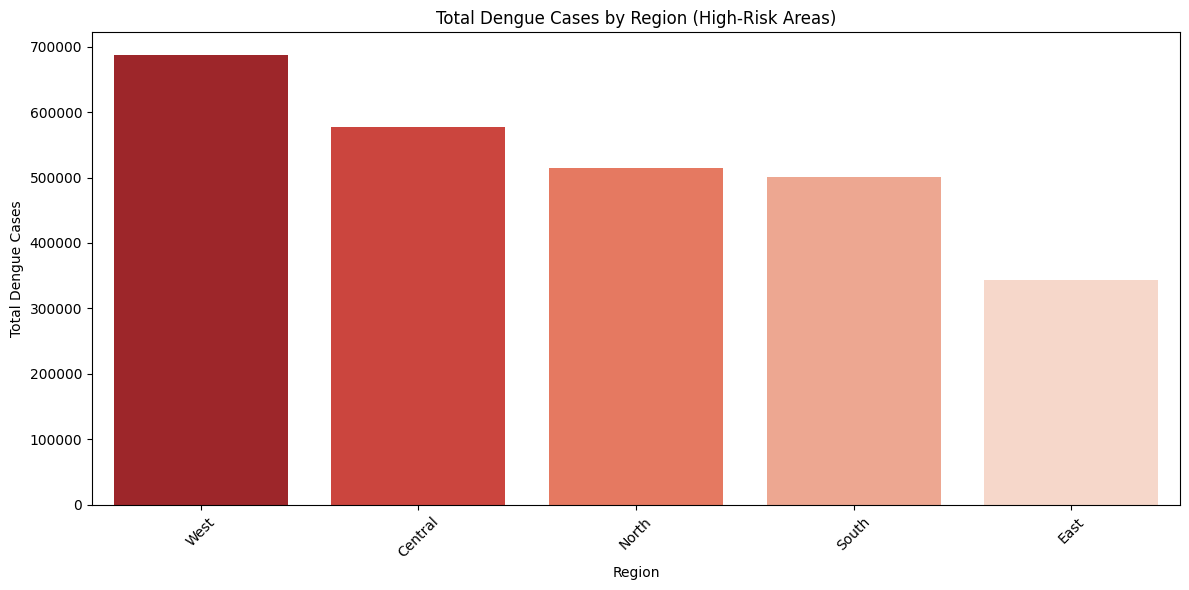

In [63]:
area_cases = df.groupby('region')['dengue_cases'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=area_cases, x='region', y='dengue_cases', palette='Reds_r')
plt.title('Total Dengue Cases by Region (High-Risk Areas)')
plt.ylabel('Total Dengue Cases')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-64-2916480670.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_cases, x='month', y='dengue_cases', palette='Oranges_r')


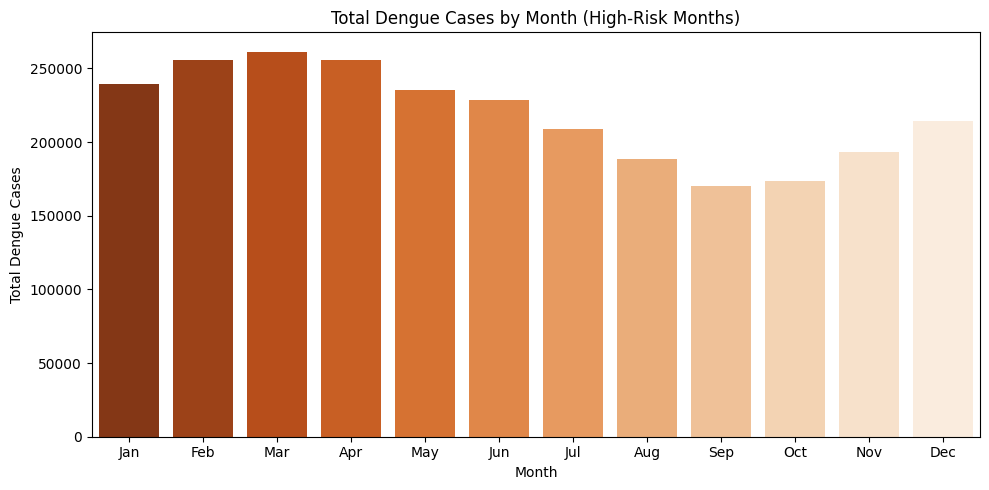

In [64]:
monthly_cases = df.groupby('month')['dengue_cases'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_cases, x='month', y='dengue_cases', palette='Oranges_r')
plt.title('Total Dengue Cases by Month (High-Risk Months)')
plt.xlabel('Month')
plt.ylabel('Total Dengue Cases')
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()


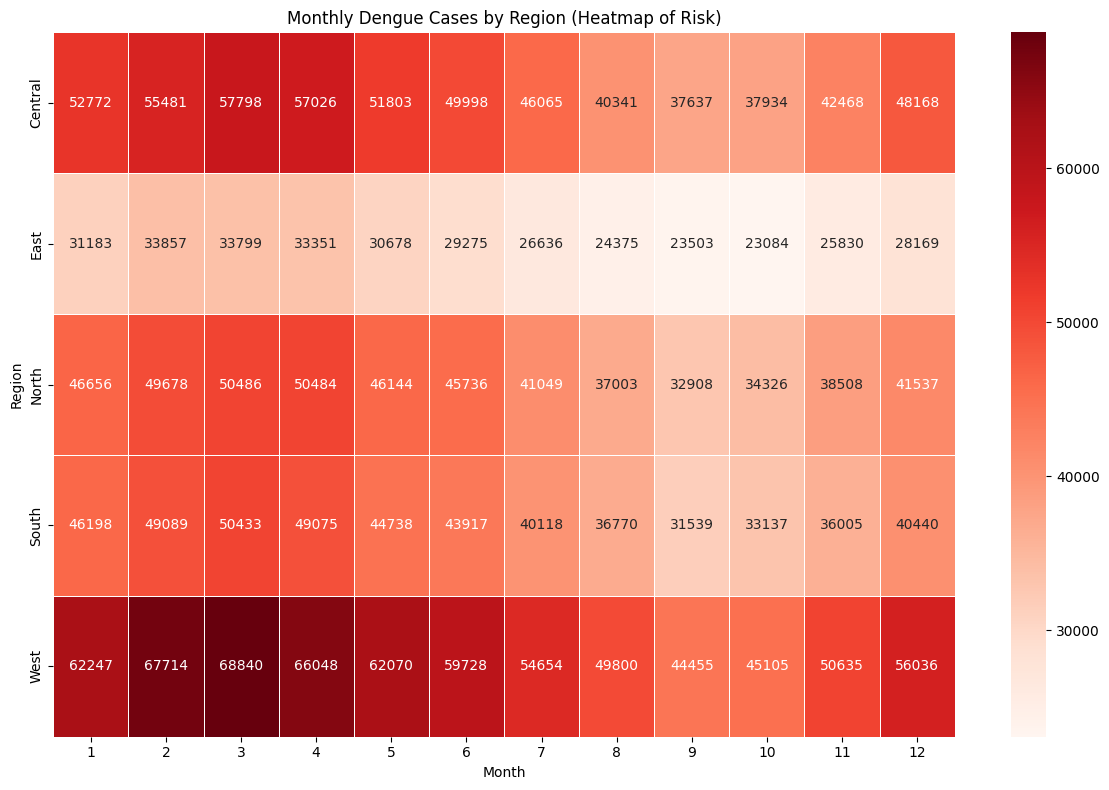

In [65]:
heatmap_data = df.groupby(['region', 'month'])['dengue_cases'].sum().unstack()


plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt=".0f", linewidths=0.5)
plt.title('Monthly Dengue Cases by Region (Heatmap of Risk)')
plt.xlabel('Month')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

### **ALIGN WITH METEOROLOGICAL DATA**

In [66]:
agg_df = df.groupby(['region', 'month']).agg({
    'dengue_cases': 'sum',
    'avg_temp_c': 'mean',
    'precipitation_mm': 'mean',
    'uv_index': 'mean',
    'air_quality_index': 'mean'
}).reset_index()

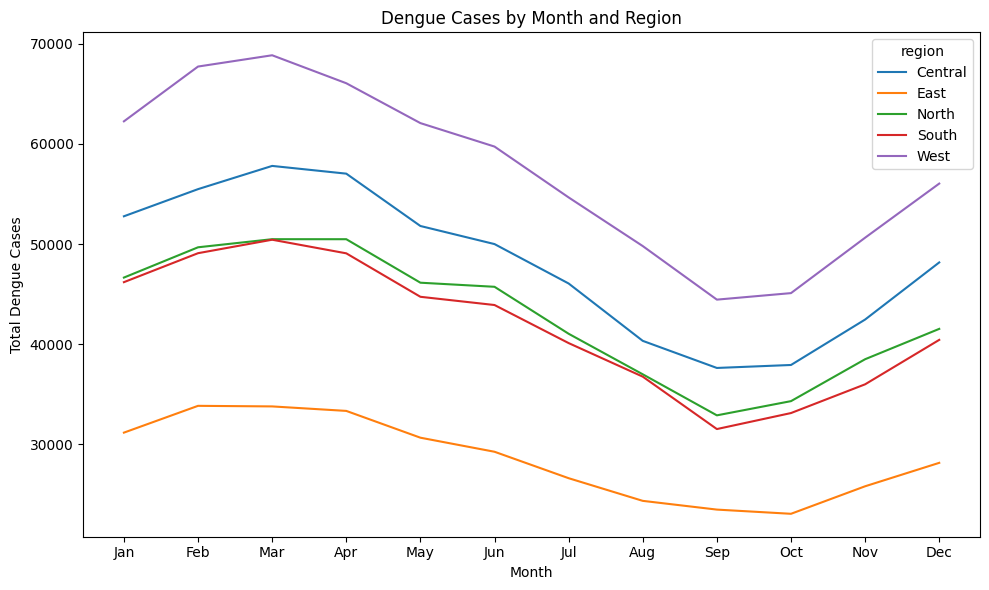

In [67]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=agg_df, x='month', y='dengue_cases', hue='region', palette='tab10')
plt.title('Dengue Cases by Month and Region')
plt.xlabel('Month')
plt.ylabel('Total Dengue Cases')
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()


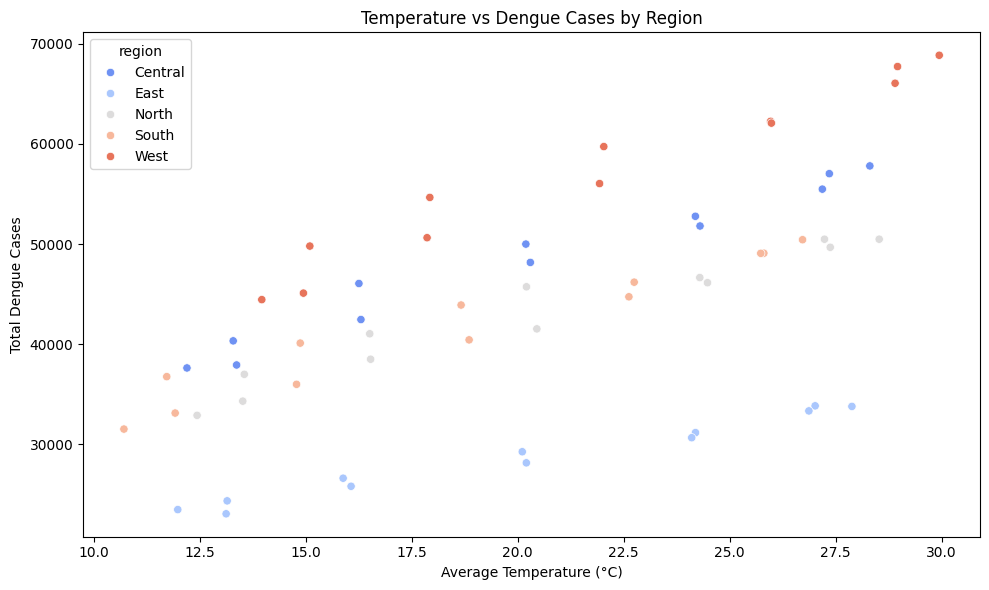

In [68]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=agg_df, x='avg_temp_c', y='dengue_cases', hue='region', palette='coolwarm')
plt.title('Temperature vs Dengue Cases by Region')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Total Dengue Cases')
plt.tight_layout()
plt.show()

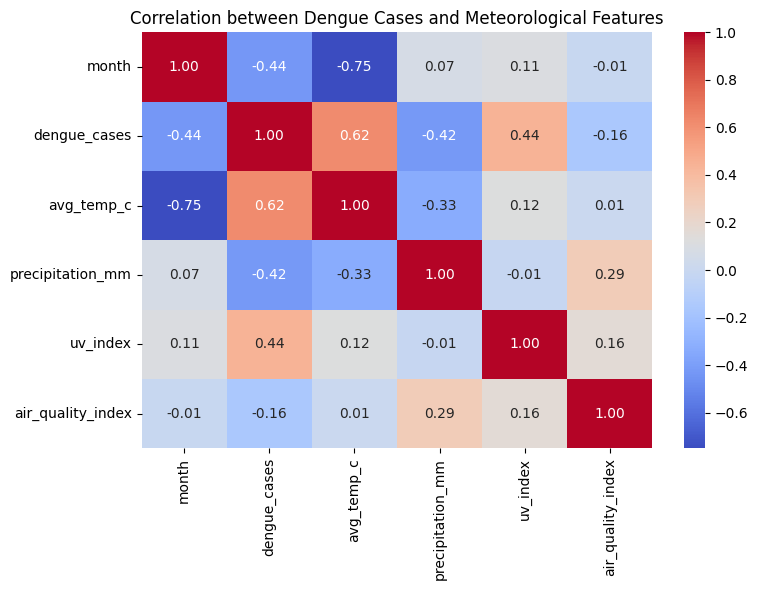

In [54]:
corr = agg_df.drop(columns=['region']).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Dengue Cases and Meteorological Features')
plt.tight_layout()
plt.show()
